In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import MaxQuant_Postprocessing_Functions as mq
import pandas as pd
import re
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [3]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# Classify mouse tissue using protein and peptide abundance data
* Use proteinGroups.txt or peptides.txt outputted from MaxQuant
* SVC variations
* K neighbors
* Decision tree

** With train-test split, test_size = 0.4:**

Algorithm | Accuracy Score
:-----:|:-----:
SVC kernel = linear | 1.0
LinearSVC | 0.75 \*
SVC kernel = rbf | 0.167
SVC kernel = poly | 1.0
KNN | 1.0
Decision Tree | 0.67 \*

\* varies

## Load and clean mouse data

In [4]:
file = "D:\proteinGroups.txt"

df = mq.load_df(file)
df = mq.clean_weakly_identified(df)
df = mq.remove_dup_proteinIDs(df)

iBAQ_df = mq.slice_by_column(df, 'protein', 'iBAQ ')

# Rename columns so that all instances "before" string are replaced with "after" string
def rename_columns(df, before, after):
    columns = df.columns.values.tolist()
    new_columns = []
    for column in columns:
        new_column = re.sub(before, after, column)
        new_columns.append(new_column)
        
    return new_columns

iBAQ_df.columns = rename_columns(iBAQ_df, 'Adult', 'Mouse')

groups = ['Brain', 'Heart', 'Kidney', 'Liver', 'Lung']
organ_columns = {} # 'Liver': ['iBAQ 04_Liver', 'iBAQ 05_Liver', ...]
organ_counts = {} # 'Liver': 
    
iBAQ_df = mq.filter_low_observed(iBAQ_df, groups, organ_columns, organ_counts)

### Function to replace low abundance values with 0

In [5]:
### Replace low abundance values with 0
def replace_with_zero(x):
    min_val = 7
    
    if type(x) is str:
        return x
    
    elif pd.isnull(x) or x < min_val:
        return 0
    
    else:
        return x
    
#iBAQ_df.applymap(replace_with_zero)

## Normalize data and impute missing values with (data frame minimum/2)

In [6]:
mq.log2_normalize(iBAQ_df)
mq.median_normalize(iBAQ_df)

iBAQ_df['Majority protein IDs'] = iBAQ_df['Majority protein IDs'].str[:-6] # strip off '_Mouse'
iBAQ_df.set_index('Majority protein IDs', inplace = True)

df_min = iBAQ_df.min().min()
impute_val = df_min/2
iBAQ_df = iBAQ_df.fillna(impute_val)

#iBAQ_df = mq.impute_missing(iBAQ_df) TODO change method to work whether df is indexed or not

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:151: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,1:] = np.log2(df.iloc[:,1:])


## Map each column name to a corresponding label

In [7]:
"""
Args: 
    df (dataframe)
    columns (list of strings): list of all column names in df
    organ_to_columns (dict): mapping of each organ to its column names {str: list of str}
    
Returns: 
    List of strings representing the labels for each dataframe column
"""
def get_labels(df, columns, organ_to_columns):
    labels = []

    for column in columns:
        key = next(key for key, value in organ_to_columns.items() if column in value)
        labels.append(key)
        
    return labels

In [8]:
iBAQ_df = iBAQ_df[organ_columns['Brain'] + organ_columns['Heart'] + organ_columns['Kidney'] + organ_columns['Liver'] + organ_columns['Lung']]

columns = iBAQ_df.columns.values.tolist()
col_labels = get_labels(iBAQ_df, columns, organ_columns)

print(columns)
print(col_labels)

['iBAQ Mouse_07_Brain', 'iBAQ Mouse_08_Brain', 'iBAQ Mouse_09_Brain', 'iBAQ Mouse_10_Brain', 'iBAQ Mouse_11_Brain', 'iBAQ Mouse_12_Brain', 'iBAQ Mouse_07_Heart', 'iBAQ Mouse_08_Heart', 'iBAQ Mouse_09_Heart', 'iBAQ Mouse_10_Heart', 'iBAQ Mouse_11_Heart', 'iBAQ Mouse_12_Heart', 'iBAQ Mouse_07_Kidney', 'iBAQ Mouse_08_Kidney', 'iBAQ Mouse_09_Kidney', 'iBAQ Mouse_10_Kidney', 'iBAQ Mouse_11_Kidney', 'iBAQ Mouse_12_Kidney', 'iBAQ Mouse_04_Liver', 'iBAQ Mouse_05_Liver', 'iBAQ Mouse_06_Liver', 'iBAQ Mouse_07_Liver', 'iBAQ Mouse_08_Liver', 'iBAQ Mouse_09_Liver', 'iBAQ Mouse_07_Lung', 'iBAQ Mouse_08_Lung', 'iBAQ Mouse_09_Lung', 'iBAQ Mouse_10_Lung', 'iBAQ Mouse_11_Lung', 'iBAQ Mouse_12_Lung']
['Brain', 'Brain', 'Brain', 'Brain', 'Brain', 'Brain', 'Heart', 'Heart', 'Heart', 'Heart', 'Heart', 'Heart', 'Kidney', 'Kidney', 'Kidney', 'Kidney', 'Kidney', 'Kidney', 'Liver', 'Liver', 'Liver', 'Liver', 'Liver', 'Liver', 'Lung', 'Lung', 'Lung', 'Lung', 'Lung', 'Lung']


## Split data and labels into test and train groups
* X_train and X_test represent raw subsets of the original dataframe
* X_t_train and X_t_test represent data transformed by PCA

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn import preprocessing

# Transpose df so that proteins are columns (components)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(iBAQ_df.T, col_labels, test_size=0.5, random_state=0, stratify=col_labels)

print(X_train.shape)
print(X_test.shape)

(15, 4399)
(15, 4399)


C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Threshold Test data to simulate lower-quality data with fewer attributes

In [10]:
from sklearn.feature_selection import SelectPercentile
import math

num_rows = X_test.shape[1]

tenth_df = X_test.drop(X_test.columns[list(range(math.floor(num_rows*(9/10))))], axis=1)
quarter_df = X_test.drop(X_test.columns[list(range(math.floor(num_rows*(3/4))))], axis=1)
half_df = X_test.drop(X_test.columns[list(range(num_rows//2))], axis=1)
three_quarters_df = X_test.drop(X_test.columns[list(range(num_rows//4))], axis=1)
nine_tenths_df = X_test.drop(X_test.columns[list(range(num_rows//10))], axis=1)

### By Percentile
#X_test = SelectPercentile(percentile=10).fit_transform(X_test, y_test)

### Randomly
X_test = tenth_df

print(X_test.shape)

(15, 440)


In [11]:
### Create "filler" array containing the imputed value to stand in for attributes that have been removed

total_attributes = X_train.shape[1]

filler_array = np.full((X_test.shape[0], total_attributes - X_test.shape[1]), impute_val)
filler_array.shape

(15, 3959)

In [12]:
### Combine filler array to reduced X_test to match training data shape for classification

X_test = np.concatenate((X_test, filler_array), axis=1)
X_test.shape

(15, 4399)

### Threshold portion of training data to simulate training on a mix of high- and low- quality data. Test with cross-validation

In [13]:
## Combine X_test back with X_train

thresholded_df = np.concatenate((X_train.T, X_test.T), axis=1)

thresholded_labels = y_train + y_test
thresholded_df = pd.DataFrame(thresholded_df, columns = thresholded_labels)

thresholded_df.set_index(iBAQ_df.index, inplace=True)

print(thresholded_df.shape)

(4399, 30)


## Draw PCA plots

In [14]:
import matplotlib.pyplot as plt

base_dir = 'D:\\Images\\Mouse_Data_Thresholding\\Original_'
color_mapping = mq.map_colors(groups, organ_columns)
columns = iBAQ_df.columns.values.tolist()

whole_df_pca, whole_df_pca_data = mq.do_pca(iBAQ_df.copy(), 'protein', scale=False)
per_var, labels = mq.make_scree_plot(whole_df_pca, base_dir)
mq.draw_pca_graph(columns, whole_df_pca_data, base_dir, color_mapping, per_var, labels)

In [15]:
pca = PCA(n_components=2)
#X_train = preprocessing.scale(X_train)
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

print(X_t_train.shape)
print(X_t_test.shape)
print(y_train)

(15, 2)
(15, 2)
['Heart', 'Lung', 'Kidney', 'Liver', 'Lung', 'Kidney', 'Liver', 'Lung', 'Liver', 'Brain', 'Kidney', 'Heart', 'Brain', 'Brain', 'Heart']


In [16]:
print(mq.top_n_loading_scores(pca, iBAQ_df, 5))

Majority protein IDs
SYUB     0.052466
SCRN1    0.049333
PCP4     0.048960
CADM3    0.047605
NEUM     0.046864
dtype: float64


## Classify

### SVC and Variations

In [17]:
#########################
#
# Basic SVC Classification with train-test split
#
#########################

from sklearn.metrics import accuracy_score

clf = SVC(C=1)
clf.fit(X_t_train, y_train)
y_pred = clf.predict(X_t_test)

print('score', accuracy_score(y_pred, y_test))
print('pred label', clf.predict(X_t_test))
print('actual', y_test)

score 0.2
pred label ['Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney'
 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain', 'Heart', 'Kidney', 'Heart', 'Liver', 'Brain']


In [18]:
#########################
#
# Basic SVC Classification with cross-validation
#
#########################
clf2 = SVC(C=1)
#scores = cross_val_score(clf2, iBAQ_df.T, col_labels, cv=4)
scores = cross_val_score(clf2, thresholded_df.T, thresholded_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.2  0.6  1.   1. ]
Accuracy: 0.70 (+/- 0.66)


In [19]:
from sklearn.svm import LinearSVC

#########################
#
# SVC variations with train-test split
#
#########################

def try_SVC_models(X_train, y_train, X_test, y_test):
    C = 1.0  # SVM regularization parameter
    models = (SVC(kernel='linear', C=C),
              LinearSVC(C=C),
              SVC(kernel='rbf', gamma=0.7, C=C),
              SVC(kernel='poly', degree=3, C=C))

    # Fit all the models
    models = (clf.fit(X_train, y_train) for clf in models)

    for model in models:
        model_y_pred = model.predict(X_test)
        print('\n*** Model: ', model, '\n')
        print('score', accuracy_score(model_y_pred, y_test))
        print('pred label', model_y_pred)
        print('actual', y_test)

In [20]:
try_SVC_models(X_t_train, y_train, X_t_test, y_test)


*** Model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

score 0.2
pred label ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain', 'Heart', 'Kidney', 'Heart', 'Liver', 'Brain']

*** Model:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 

score 0.2
pred label ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain',

### K Neighbors

#### Train-test split 

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_t_train, y_train)
y_pred = knn.predict(X_t_test)

print('score', accuracy_score(y_pred, y_test))
print('pred', y_pred)
print('actual', y_test)

score 0.2
pred ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain', 'Heart', 'Kidney', 'Heart', 'Liver', 'Brain']


#### Cross-validation

In [22]:
knn2 = KNeighborsClassifier()
#scores = cross_val_score(knn2, iBAQ_df.T, col_labels, cv=4)
scores = cross_val_score(knn2, thresholded_df.T, thresholded_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

knn2.fit(iBAQ_df.T, col_labels)

[ 0.2  0.6  0.6  0.6]
Accuracy: 0.50 (+/- 0.35)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### SKLearn Pipeline: Train-test split, PCA transformation

In [23]:
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaling', StandardScaler()),
                 ('pca', PCA()),
                 ('knn', KNeighborsClassifier())])

pipe.fit(X_train, y_train)

#print(cross_val_score(pipe, iBAQ_df.T, col_labels))

pipe_pred = pipe.predict(X_test)
print('score', accuracy_score(pipe_pred, y_test))
print('pred', pipe_pred)
print('actual', y_test)

score 0.2
pred ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain', 'Heart', 'Kidney', 'Heart', 'Liver', 'Brain']


### Decision Tree

In [24]:
decision_tree_clf = tree.DecisionTreeClassifier()
decision_tree_clf = decision_tree_clf.fit(X_t_train, y_train)
dt_pred = decision_tree_clf.predict(X_t_test)

print('score', accuracy_score(dt_pred, y_test))
print('pred', dt_pred)
print('actual', y_test)

score 0.2
pred ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain', 'Heart', 'Kidney', 'Heart', 'Liver', 'Brain']


In [25]:
dt2 = tree.DecisionTreeClassifier()
#scores,= cross_val_score(dt2, iBAQ_df.T, col_labels, cv=4)
scores = cross_val_score(dt2, thresholded_df.T, thresholded_labels, cv=4)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.6  0.7  1.   0.6]
Accuracy: 0.72 (+/- 0.33)


### Logistic Regression

In [26]:
import Classification_Utils as cu

#lr = cu.logistic_regression_model_crossval(iBAQ_df.T, col_labels, 4)
lr = cu.logistic_regression_model_crossval(thresholded_df.T, thresholded_labels, 4)

Scores: [ 1.  1.  1.  1.]
Accuracy: 1.00 (+/- 0.00)


### Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb = gnb.fit(X_t_train, y_train)
gnb_pred = gnb.predict(X_t_test)

print('score', accuracy_score(gnb_pred, y_test))
print('pred', gnb_pred)
print('actual', y_test)

score 0.2
pred ['Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart'
 'Heart' 'Heart' 'Heart' 'Heart' 'Heart' 'Heart']
actual ['Lung', 'Kidney', 'Brain', 'Kidney', 'Heart', 'Lung', 'Liver', 'Lung', 'Liver', 'Brain', 'Heart', 'Kidney', 'Heart', 'Liver', 'Brain']


In [28]:
#gnb2 = cu.bayes_gaussian_model_crossval(iBAQ_df.T, col_labels, 4)
gnb2 = cu.bayes_gaussian_model_crossval(thresholded_df.T, thresholded_labels, 4)

Scores: [ 1.   0.8  0.4  0.2]
Accuracy: 0.60 (+/- 0.63)


In [29]:
mnb = cu.bayes_multinomial_model_crossval(thresholded_df.T, thresholded_labels, 4)

Scores: [ 0.8  0.7  0.6  0.8]
Accuracy: 0.73 (+/- 0.17)


### Gradient Boosting

In [30]:
gbc = cu.gradient_boosting_crossval(thresholded_df.T, thresholded_labels, 4)

Scores: [ 0.9  0.9  1.   0.8]
Accuracy: 0.90 (+/- 0.14)


# Classify using Peptide Data
* Use peptides.txt output from MaxQuant
* SVC varations
* K nearest neighbors
* Decision tree

** With train-test split, test_size = 0.4: **

Algorithm | Accuracy Score
:-----:|:-----:
SVC kernel = linear | 1.0
LinearSVC | 1.0 \*
SVC kernel = rbf | 0.167
SVC kernel = poly | 0.917
KNN | 1.0
Decision Tree | 1.0 \*

\* varies

## Load and clean peptide data

In [355]:
peptide_file = "D:\peptides.txt"

peptide_df = mq.load_df(peptide_file)
peptide_df = mq.slice_by_column(peptide_df, 'peptide', 'LFQ')
peptide_df.columns = rename_columns(peptide_df, 'Adult', 'Mouse')

peptide_organ_columns = {}
peptide_organ_counts = {}
peptide_df = mq.filter_low_observed(peptide_df, groups, peptide_organ_columns, peptide_organ_counts)
mq.log2_normalize(peptide_df)
mq.median_normalize(peptide_df)

peptide_df = peptide_df.replace(r'\n','', regex=True)
peptide_df.set_index('Sequence', inplace = True)
peptide_df = mq.impute_missing(peptide_df)

peptide_columns = peptide_df.columns.values.tolist()
peptide_labels = get_labels(peptide_df, peptide_columns, peptide_organ_columns)
print(peptide_labels)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:150: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,1:] = np.log2(df.iloc[:,1:])


['Liver', 'Liver', 'Liver', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Brain', 'Heart', 'Kidney', 'Lung', 'Brain', 'Heart', 'Kidney', 'Lung', 'Brain', 'Heart', 'Kidney', 'Lung']


## Split data and labels into test and train groups

In [356]:
scaled_peptide_data = preprocessing.scale(peptide_df.T)

### Randomly split:
peptide_X_train, peptide_X_test, peptide_y_train, peptide_y_test = cross_validation.train_test_split(peptide_df.T, peptide_labels, test_size=0.4, random_state=0, stratify=peptide_labels)

peptide_pca = PCA(n_components=4)
peptide_pca.fit(peptide_X_train)
peptide_X_t_train = peptide_pca.transform(peptide_X_train)
peptide_X_t_test = peptide_pca.transform(peptide_X_test)

print(peptide_X_t_train.shape)
print(peptide_X_t_test.shape)
print(peptide_y_train)

(18, 4)
(12, 4)
['Lung', 'Liver', 'Heart', 'Heart', 'Kidney', 'Liver', 'Heart', 'Kidney', 'Kidney', 'Liver', 'Brain', 'Kidney', 'Brain', 'Brain', 'Brain', 'Lung', 'Lung', 'Heart']


## Draw PCA plots for peptide data

In [357]:
peptide_dir = base_dir + 'Mouse_Peptide_'
peptide_color_mapping = mq.map_colors(groups, peptide_organ_columns)
columns = peptide_df.columns.values.tolist()

peptide_pca, peptide_pca_data = mq.do_pca(peptide_df.copy(), scale=False)
peptide_per_var, peptide_labels = mq.make_scree_plot(peptide_pca, peptide_dir)
mq.draw_pca_graph(columns, peptide_pca_data, peptide_dir, peptide_color_mapping, peptide_per_var, peptide_labels)


## SVC

In [358]:
peptide_clf = SVC()
peptide_clf.fit(peptide_X_t_train, peptide_y_train)
peptide_y_pred = peptide_clf.predict(peptide_X_t_test)

print('score', accuracy_score(peptide_y_pred, peptide_y_test))
print('pred label', peptide_y_pred)
print('actual', peptide_y_test)

score 0.166666666667
pred label ['Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney' 'Kidney'
 'Kidney' 'Kidney' 'Kidney' 'Kidney']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


In [359]:
try_SVC_models(peptide_X_t_train, peptide_y_train, peptide_X_t_test, peptide_y_test)


*** Model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

score 1.0
pred label ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']

*** Model:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 

score 1.0
pred label ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']

*** Model:  SVC(C=1.0, cache_size=200, class_weight=None, 

## K Nearest Neighbors

In [360]:
peptide_knn = KNeighborsClassifier()
peptide_knn.fit(peptide_X_t_train, peptide_y_train)
peptide_y_pred = peptide_knn.predict(peptide_X_t_test)

print('score', accuracy_score(peptide_y_pred, peptide_y_test))
print('pred', peptide_y_pred)
print('actual', peptide_y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


## Decision Tree

In [361]:
peptide_dt_clf = tree.DecisionTreeClassifier()
peptide_dt_clf = peptide_dt_clf.fit(peptide_X_t_train, peptide_y_train)
peptide_dt_pred = peptide_dt_clf.predict(peptide_X_t_test)

print('score', accuracy_score(peptide_dt_pred, peptide_y_test))
print('pred', peptide_dt_pred)
print('actual', peptide_y_test)

score 1.0
pred ['Brain' 'Lung' 'Lung' 'Kidney' 'Heart' 'Liver' 'Liver' 'Heart' 'Liver'
 'Kidney' 'Lung' 'Brain']
actual ['Brain', 'Lung', 'Lung', 'Kidney', 'Heart', 'Liver', 'Liver', 'Heart', 'Liver', 'Kidney', 'Lung', 'Brain']


Confusion matrix, without normalization
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 3]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


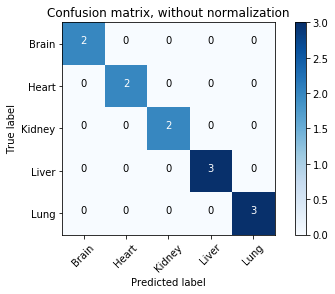

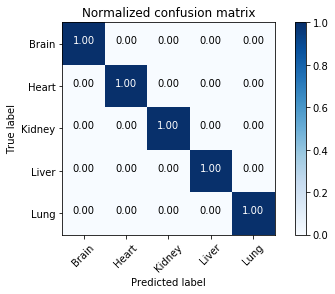

In [362]:
### Confusion matrix shows which labels are being misclassified
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(peptide_y_test, peptide_dt_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=groups,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=groups, normalize=True,
                      title='Normalized confusion matrix')

plt.show()